In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults

%matplotlib inline
import warnings
warnings.simplefilter("ignore")


In [4]:
df_monitores = pd.read_csv("../data/dados_para_processamento/df_monitores.csv", sep =',',
                              parse_dates = ['ds'],
                              encoding = 'utf-8')
#df_alimentacao = df_alimentacao[df_alimentacao['Data_Venda'] != '2020-01']

In [5]:
df_monitores = df_monitores[df_monitores.ds != '2020-01-01'].sort_index(ascending= True)

In [6]:
df_monitores

,Produto,y,ds
0,"Monitor 27"" Full HD",1,2019-01-01
1,"Monitor gamer 27"" 4K",1,2019-01-01
2,Notebook Macbook Pro,1,2019-01-01
3,"Monitor 27"" Full HD",1,2019-01-01
4,TV Tela Plana,1,2019-01-01
...,...,...,...
33538,Notebook Macbook Pro,1,2019-12-01
33539,Notebook Macbook Pro,1,2019-12-01
33540,"Monitor Ultrawide 34""",1,2019-12-01
33541,"Monitor 20""",1,2019-12-01


In [7]:
df_alimentacao.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33543 entries, 0 to 33542
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Produto  33543 non-null  object        
 1   y        33543 non-null  int64         
 2   ds       33543 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 786.3+ KB


In [9]:
df_monitores.Produto.nunique()

6

In [10]:
df_monitores = df_monitores.groupby(['ds', 'Produto'])["y"].sum().reset_index()

In [11]:
df_monitores.head(10)

,ds,Produto,y
0,2019-01-01,"Monitor 20""",215
1,2019-01-01,"Monitor 27"" Full HD",419
2,2019-01-01,"Monitor Ultrawide 34""",314
3,2019-01-01,"Monitor gamer 27"" 4K",312
4,2019-01-01,Notebook Macbook Pro,234
5,2019-01-01,TV Tela Plana,243
6,2019-02-01,"Monitor 20""",246
7,2019-02-01,"Monitor 27"" Full HD",475
8,2019-02-01,"Monitor Ultrawide 34""",418
9,2019-02-01,"Monitor gamer 27"" 4K",427


In [13]:
df_monitores.columns

Index(['ds', 'Produto', 'y'], dtype='object')

In [46]:
map_data = {
 '2019-01-01': 'Jan/2019',
 '2019-02-01': 'Fev/2019',
 '2019-03-01': 'Mar/2019',
 '2019-04-01': 'Abr/2019',
 '2019-05-01': 'Maio/2019',
 '2019-06-01': 'Jun/2019',
 '2019-07-01': 'Jul/2019',
 '2019-08-01': 'Ago/2019',
 '2019-09-01': 'Set/2019',
 '2019-10-01': 'Out/2019',
 '2019-11-01': 'Nov/2019',
 '2019-12-01': 'Dez/2019',
 '2020-01-01': 'Jan/2020',
 '2020-02-01': 'Fev/2020',
}

In [47]:
def preparaDF(df, list_alimentacao):
    num_plots = len(list_alimentacao)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # Arredonda para cima a divisão

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

    for i, produto in enumerate(list_alimentacao):
        novo_df = df[df['Produto'] == produto]
        novo_df = novo_df.drop(columns={'Produto'})
        novo_df = novo_df.set_index('ds')['y']
        novo_df = novo_df.asfreq('MS')

        # ARIMA
        model_arima = ARIMA(novo_df, order=(0, 1, 2))
        fit_arima = model_arima.fit()

        forecast_arima = fit_arima.forecast(steps=2)

        row = i // num_cols
        col = i % num_cols

        # PLOTAGEM
        axs[row, col].plot(novo_df.index, novo_df.values, label='Dados Históricos', marker='o')
        axs[row, col].plot(forecast_arima.index, forecast_arima.values, color='red', linestyle='--', label='Projeção de Vendas', marker='o', markersize=8)
        axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.3)
        axs[row, col].plot([novo_df.index[-1], forecast_arima.index[0]], [novo_df.values[-1], forecast_arima.values[0]], color='red', linestyle='--')

        axs[row, col].set_xlabel('Mês')
        axs[row, col].set_ylabel('Quantitativo de Vendas')
        axs[row, col].set_title(f'Previsão de Vendas - {produto}', y=1.05)
        axs[row, col].legend()


        axs[row, col].tick_params(axis='y', colors='gray')
        axs[row, col].set_xticks([pd.Timestamp(date) for date in map_data.keys()])
        axs[row, col].set_xticklabels(map_data.values(), rotation=45, ha='right', color='gray') 

        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

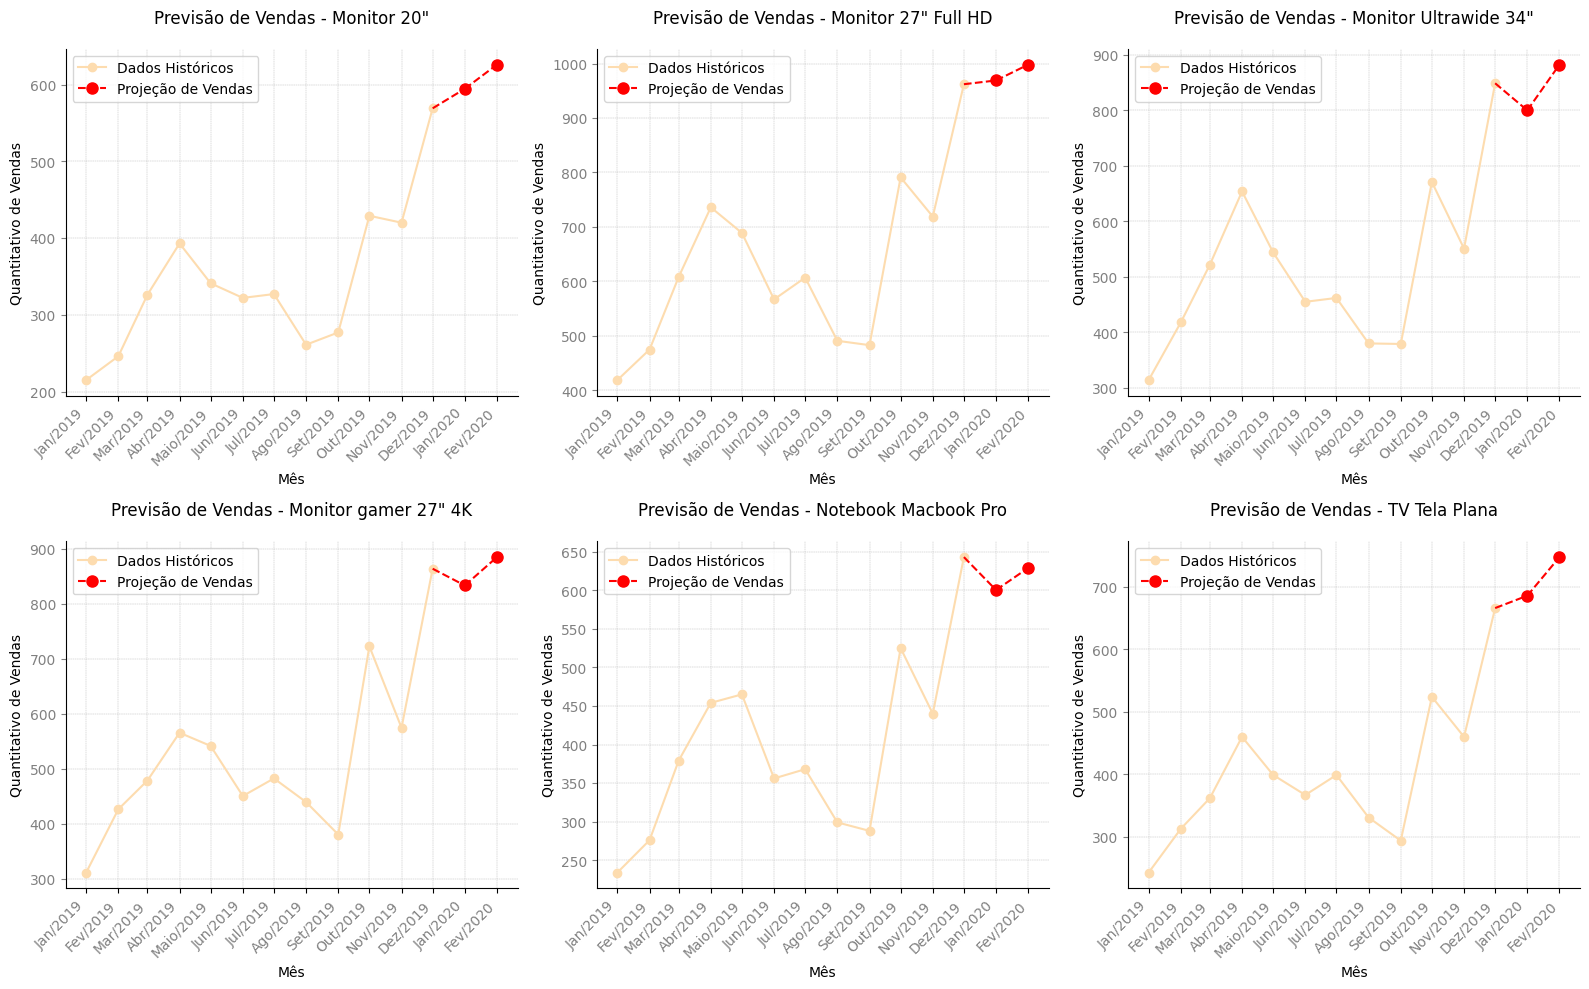

In [48]:
list_alimentacao = df_monitores['Produto'].unique()

sns.set_palette("OrRd", 4)

preparaDF(df_monitores, list_alimentacao)